In [12]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import pandas as pd
import math
import random
import numpy as np 
import scipy.misc
import matplotlib.pyplot as plt


In [14]:
URL = 'https://s3.us-east-2.amazonaws.com/kaggle551/'

train_x = pd.read_csv(URL + 'train_x_preproc.csv', header=None)
train_y = pd.read_csv(URL + 'train_y.csv', header=None)

train_x = np.array(train_x.as_matrix())
train_y = np.array(train_y[0])

test_x = pd.read_csv(URL + 'test_x_preproc.csv', header=None)
test_x = np.array(test_x.as_matrix())

print('data retrieved')

data retrieved


In [0]:
train_x[train_x < 235] = 0 
test_x[test_x < 235] = 0 

train_x /= 255.0
test_x /= 255.0


In [7]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(50000, 4096)
(50000,)
(10000, 4096)


In [0]:
# sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(x):
    return 1.0 - x**2

# Make a matrix 
def matrix(m, n, fill=0.0):
    return np.zeros(shape=(m,n)) + fill

# Make a random matrix
def rand_matrix(m, n, a=0, b=1):
	return np.random.rand(m, n) * (b - a) + a

# use logistic regression loss function 
def loss_fn(predict, truth):
    n = len(truth)
    loss = (- 1 / n) * np.sum(truth * np.log(predict) + (1 - truth) * (np.log(1 - predict)))
    loss = np.squeeze(loss)

    return loss

In [0]:
class NN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni
        self.nh = nh
        self.no = no
        
        # bias vectors 
#         self.bh = np.zeros((1, self.nh))
#         self.bo = np.zeros((1, self.no))
        self.bh = np.ones(self.nh)
        self.bo = np.ones(self.no)
    

        # create weights
        # default to range (-0.5, 0.5)
        self.wh = rand_matrix(self.ni, self.nh, -0.5, 0.5)
        self.wo = rand_matrix(self.nh, self.no, -0.5, 0.5)
        
    
    # training feed forward, obtain output from weight matrices and bias vectors
    def propagate(self, inputs):
        self.ai = inputs

        # hidden layers activations
        #bh is bias of hidden layers
        self.ah = np.dot(self.ai, self.wh) + self.bh

        # hidden output 
        self.oh = np.tanh(self.ah)

        # output layers activations
        self.ao = np.dot(self.ah, self.wo) + self.bo
        
        #h output layers output 
        self.oo = sigmoid(self.ao)

    # training back propagation, updates neural network's weight matrices and bias vectors
    def backPropagate(self, x, y, eta):
        n = x.shape[0]
        self.dao = self.oo - y
        self.dwo = np.dot(self.oh.T, self.dao) / n
        self.dbo = np.sum(self.dao) / n
        
        self.dah = np.dot(self.dao, self.wo.T)*(1-np.tanh(self.ah))
        self.dwh = np.dot(x.T, self.dah) / n
        self.dbh = np.sum(self.dah) / n
        
        #update weights using gradient descent method. learning rate = eta
        self.wo = self.wo - eta * self.dwo
        self.wh = self.wh - eta * self.dwh
        self.bo = self.bo - eta * self.dbo
        self.bh = self.bh - eta * self.dbh
        
        
    
    def predict(self, x):
        ah = np.dot(x, self.wh) + self.bh

        # hidden output 
        oh = np.tanh(ah)

        # output layers activations
        ao = np.dot(ah, self.wo) + self.bo
        
        #h output layers output 
        oo = sigmoid(ao)
        return oo
      
    
    # takes in Y     
    def train(self, X, Y, iterations = 1000, eta=0.5):
        trend = []
        
        # create output matrix
        Y_m = np.zeros((X.shape[0], 10))
        for i in range(len(Y)):
          Y_m[i][int(Y[i])] = 1

        for i in range(iterations):
            output = self.propagate(X)
            self.backPropagate(X, Y_m, eta)

            pred = np.argmax(self.oo, axis=1)
            loss = loss_fn(self.oo, Y_m)
            diff = Y - pred
            acc = (diff == 0).sum() / len(Y)
            if( i % (iterations / 100) == 0): 
              trend.append([acc, loss])
              print("iteration ", i, " :    training acc: ", acc, "   training loss: ", loss)

        return trend

In [0]:
nn = NN(ni=4096, nh=6, no=10)

In [52]:
nn.propagate(train_x)
print("output: ", nn.ao)
print("output shape: ", nn.ao.shape)

output:  [[-2.38073109 -4.67663621 -3.2488232  ... -2.3355193  -3.37784973
  -6.0460432 ]
 [-2.07071252 -3.92317283 -2.30168386 ... -1.7732754  -4.98692747
  -5.49520772]
 [-3.21069716  0.56758109 -0.91953393 ... -2.64763564 -4.10285608
  -6.14584302]
 ...
 [-1.45052863 -6.28624402 -3.14098832 ... -0.78301937 -3.36092328
  -3.78289706]
 [-1.43457474 -5.2075142  -4.43390331 ... -3.2506142  -3.99810985
  -6.77302833]
 [-2.1950731  -3.47372842  0.0717446  ... -0.47794964 -6.17378913
  -4.16986025]]
output shape:  (50000, 10)


In [53]:
cross_validation=5
valid_split = 0.05

# best_pred = [accuracy, nn, training trend]
best_pred = (0, 0, [])

for valid in range(cross_validation):
    print("\nCross Validation fold ", valid)
  
    # randomly split the dataset into validation and training sets 
    mask = np.random.rand(train_x.shape[0]) <= valid_split
    t_x = train_x[mask]
    t_y = train_y[mask]

    v_x = train_x[~mask]
    v_y = train_y[~mask]
    
    nn = NN(ni=4096, nh=6, no=10)
    
    res = nn.train(t_x, t_y, 2000)
    
    # validate with validation set after the training
    v_o = nn.predict(v_x)
    pred = np.argmax(v_o, axis=1)
    diff = v_y - pred
    acc = (diff == 0).sum() / len(v_y)
   
    
    if(acc > best_pred[0]): best_pred = (acc, nn, res) 



Cross Validation fold  0
iteration  0  :    training acc:  0.11403853716083366    training loss:  19.624486824491612
iteration  20  :    training acc:  0.11718442784113252    training loss:  4.147369099907744
iteration  40  :    training acc:  0.11049941014549744    training loss:  4.506449693848254
iteration  60  :    training acc:  0.10774675580023595    training loss:  4.519086611630984
iteration  80  :    training acc:  0.10617381046008652    training loss:  4.429468353575487
iteration  100  :    training acc:  0.11443177349587103    training loss:  4.374235212353267
iteration  120  :    training acc:  0.10656704679512387    training loss:  4.618412310935821
iteration  140  :    training acc:  0.10735351946519858    training loss:  4.783145045948446
iteration  160  :    training acc:  0.10696028313016123    training loss:  4.631687219094227
iteration  180  :    training acc:  0.1081399921352733    training loss:  4.934498492464705
iteration  200  :    training acc:  0.123869445536

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


iteration  1420  :    training acc:  0.16948486040110106    training loss:  6.4585837099167405


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


iteration  1440  :    training acc:  0.13291388124262682    training loss:  inf
iteration  1460  :    training acc:  0.13999213527329926    training loss:  nan
iteration  1480  :    training acc:  0.18128195045222179    training loss:  inf
iteration  1500  :    training acc:  0.12072355485646874    training loss:  nan
iteration  1520  :    training acc:  0.1183641368462446    training loss:  inf
iteration  1540  :    training acc:  0.11915060951631931    training loss:  inf
iteration  1560  :    training acc:  0.15572158867479355    training loss:  nan
iteration  1580  :    training acc:  0.12622886354699175    training loss:  nan
iteration  1600  :    training acc:  0.1403853716083366    training loss:  nan
iteration  1620  :    training acc:  0.11600471883602045    training loss:  nan
iteration  1640  :    training acc:  0.15690129767990563    training loss:  nan
iteration  1660  :    training acc:  0.17577664176169877    training loss:  nan
iteration  1680  :    training acc:  0.119

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


iteration  1800  :    training acc:  0.15021627998427053    training loss:  nan
iteration  1820  :    training acc:  0.12780180888714118    training loss:  nan
iteration  1840  :    training acc:  0.11797090051120723    training loss:  nan
iteration  1860  :    training acc:  0.1238694455367676    training loss:  nan
iteration  1880  :    training acc:  0.1423515532835234    training loss:  nan
iteration  1900  :    training acc:  0.12033031852143138    training loss:  nan
iteration  1920  :    training acc:  0.12622886354699175    training loss:  nan
iteration  1940  :    training acc:  0.12898151789225323    training loss:  nan
iteration  1960  :    training acc:  0.11954384585135666    training loss:  nan
iteration  1980  :    training acc:  0.14746362563900905    training loss:  nan

Cross Validation fold  1
iteration  0  :    training acc:  0.10160847391133777    training loss:  23.925115842874888
iteration  20  :    training acc:  0.09964692036092586    training loss:  5.09773225

iteration  1620  :    training acc:  0.14319340918007062    training loss:  3.8867554263463573
iteration  1640  :    training acc:  0.10435464888191448    training loss:  4.608595249335547
iteration  1660  :    training acc:  0.15339348764221264    training loss:  3.8959178141731305
iteration  1680  :    training acc:  0.12357787367595136    training loss:  3.9147171157664045
iteration  1700  :    training acc:  0.1357395056885053    training loss:  3.863927762710443
iteration  1720  :    training acc:  0.12907022361710474    training loss:  4.348772502277225
iteration  1740  :    training acc:  0.15064731267163595    training loss:  4.1569671589197
iteration  1760  :    training acc:  0.13770105923891723    training loss:  4.395011863638751
iteration  1780  :    training acc:  0.1380933699489996    training loss:  3.971796429495516
iteration  1800  :    training acc:  0.15457041977245978    training loss:  3.989838161051992
iteration  1820  :    training acc:  0.10435464888191448    t

iteration  1420  :    training acc:  0.1641434262948207    training loss:  4.372860592677519
iteration  1440  :    training acc:  0.1541832669322709    training loss:  4.952890392119028
iteration  1460  :    training acc:  0.1254980079681275    training loss:  4.918279453805513
iteration  1480  :    training acc:  0.12470119521912351    training loss:  5.334501131607965
iteration  1500  :    training acc:  0.14860557768924304    training loss:  4.45099353321917
iteration  1520  :    training acc:  0.11075697211155379    training loss:  5.122574305815827
iteration  1540  :    training acc:  0.16374501992031873    training loss:  3.711269274188175
iteration  1560  :    training acc:  0.11832669322709163    training loss:  5.23604479879193
iteration  1580  :    training acc:  0.1549800796812749    training loss:  4.71519241221914
iteration  1600  :    training acc:  0.14063745019920318    training loss:  3.9840643120724324
iteration  1620  :    training acc:  0.15617529880478087    traini

iteration  1200  :    training acc:  0.19167353668590273    training loss:  3.871482317708837
iteration  1220  :    training acc:  0.18013190436933224    training loss:  3.799428793556211
iteration  1240  :    training acc:  0.20651277823577907    training loss:  3.5101617281256368
iteration  1260  :    training acc:  0.16611706512778235    training loss:  4.770730457563197
iteration  1280  :    training acc:  0.1471558120362737    training loss:  4.131740143496369
iteration  1300  :    training acc:  0.16817807089859851    training loss:  4.316843544035342
iteration  1320  :    training acc:  0.21063478977741137    training loss:  3.8874268804701835
iteration  1340  :    training acc:  0.24196207749381698    training loss:  3.378041684309042
iteration  1360  :    training acc:  0.17889530090684255    training loss:  3.9335104979157065
iteration  1380  :    training acc:  0.17065127782357792    training loss:  3.92734646466384
iteration  1400  :    training acc:  0.21764220939818632   

iteration  980  :    training acc:  0.15019305019305018    training loss:  4.571249315795841
iteration  1000  :    training acc:  0.14787644787644788    training loss:  5.872185159095236
iteration  1020  :    training acc:  0.13938223938223937    training loss:  4.593687825441248
iteration  1040  :    training acc:  0.17297297297297298    training loss:  3.671806010076379
iteration  1060  :    training acc:  0.177992277992278    training loss:  3.793997256633013
iteration  1080  :    training acc:  0.1335907335907336    training loss:  4.107082690840424
iteration  1100  :    training acc:  0.13474903474903474    training loss:  4.9879171213386675
iteration  1120  :    training acc:  0.18030888030888031    training loss:  3.781648095811297
iteration  1140  :    training acc:  0.12084942084942085    training loss:  4.73547108270313
iteration  1160  :    training acc:  0.17683397683397684    training loss:  3.7264508178438773
iteration  1180  :    training acc:  0.14594594594594595    tra

In [0]:
best_nn = best_pred[1]

pred = best_nn.predict(test_x)
pred = np.argmax(v_o, axis=1)

arr = np.arange(len(pred))

np.savetxt('nn_prediction.csv', np.dstack((arr, pred))[0], "%d,%d", header = "Id,Label", comments='')


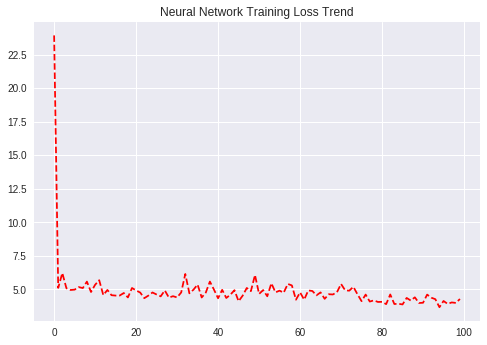

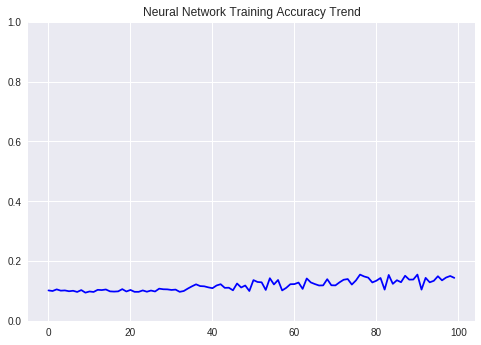

In [87]:
epoch = np.arange(len(res))

plt.figure(1)
plt.title('Neural Network Training Loss Trend')
plt.plot(epoch, res[:,1], 'r--')

plt.figure(2)
plt.title('Neural Network Training Accuracy Trend')
plt.plot(epoch, res[:,0], 'b')
plt.ylim(0, 1)

plt.show()

In [9]:
cross_validation=5
valid_split = np.arange(0.02, 0.3, 0.3)

# best_pred = [accuracy, nn, training trend]
best_pred = (0, 0, 0, [])

# best_split = [accuracy, split]

for split in valid_split:
  split_acc = 0
  for valid in range(cross_validation):
      print("\nCross Validation fold ", valid)

      # randomly split the dataset into validation and training sets 
      mask = np.random.rand(train_x.shape[0]) <= split
      t_x = train_x[mask]
      t_y = train_y[mask]

      v_x = train_x[~mask]
      v_y = train_y[~mask]

      nn = NN(ni=4096, nh=6, no=10)

      res = nn.train(t_x, t_y, 2000)

      # validate with validation set after the training
      v_o = nn.predict(v_x)
      pred = np.argmax(v_o, axis=1)
      diff = v_y - pred
      acc = (diff == 0).sum() / len(v_y)
      
      split_acc = acc / cross_validation
      
  if(split_acc > best_pred[0]): best_pred = (acc, split, nn, res) 



Cross Validation fold  0
iteration  0  :    training acc:  0.08959835221421215    training loss:  19.212018377192777


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


iteration  20  :    training acc:  0.10916580844490216    training loss:  6.016921067099159
iteration  40  :    training acc:  0.10607621009268794    training loss:  6.8177959506742
iteration  60  :    training acc:  0.10401647785787847    training loss:  5.850191781635482
iteration  80  :    training acc:  0.10401647785787847    training loss:  5.412260999941086
iteration  100  :    training acc:  0.10504634397528322    training loss:  5.205933421850757
iteration  120  :    training acc:  0.121524201853759    training loss:  5.078892825000366
iteration  140  :    training acc:  0.13079299691040164    training loss:  5.889614761416814
iteration  160  :    training acc:  0.12770339855818744    training loss:  6.42710231830367
iteration  180  :    training acc:  0.12358393408856849    training loss:  5.757856266025936
iteration  200  :    training acc:  0.11122554067971163    training loss:  5.691809703876902
iteration  220  :    training acc:  0.12873326467559218    training loss:  4.66

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


iteration  1240  :    training acc:  0.2780638516992791    training loss:  3.9523326079450554
iteration  1260  :    training acc:  0.2646755921730175    training loss:  3.7386607783421706
iteration  1280  :    training acc:  0.29042224510813597    training loss:  3.975631086613076
iteration  1300  :    training acc:  0.2883625128733265    training loss:  4.248839216492595
iteration  1320  :    training acc:  0.35015447991761073    training loss:  3.7369858707327803
iteration  1340  :    training acc:  0.28321318228630277    training loss:  4.057163670841769
iteration  1360  :    training acc:  0.3419155509783728    training loss:  3.237700595525978
iteration  1380  :    training acc:  0.26364572605561276    training loss:  4.822991888425799
iteration  1400  :    training acc:  0.243048403707518    training loss:  6.311665399268906
iteration  1420  :    training acc:  0.33161688980432547    training loss:  4.250120349762747
iteration  1440  :    training acc:  0.2646755921730175    trai

iteration  1020  :    training acc:  0.3231707317073171    training loss:  5.245444119868799
iteration  1040  :    training acc:  0.2571138211382114    training loss:  4.9706303170347645
iteration  1060  :    training acc:  0.3638211382113821    training loss:  3.57182399080702
iteration  1080  :    training acc:  0.391260162601626    training loss:  4.297042599927051
iteration  1100  :    training acc:  0.16463414634146342    training loss:  nan
iteration  1120  :    training acc:  0.37601626016260165    training loss:  7.531771125051178
iteration  1140  :    training acc:  0.30386178861788615    training loss:  5.729998770242995
iteration  1160  :    training acc:  0.25203252032520324    training loss:  nan
iteration  1180  :    training acc:  0.27134146341463417    training loss:  nan
iteration  1200  :    training acc:  0.366869918699187    training loss:  5.384509745694575
iteration  1220  :    training acc:  0.4136178861788618    training loss:  4.904074687393545
iteration  1240 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



Cross Validation fold  2
iteration  0  :    training acc:  0.11736178467507274    training loss:  22.9465860933813
iteration  20  :    training acc:  0.15033947623666344    training loss:  3.7646203656710675
iteration  40  :    training acc:  0.15324927255092144    training loss:  3.6849586028579937
iteration  60  :    training acc:  0.16100872938894278    training loss:  3.6381204622162455
iteration  80  :    training acc:  0.16197866149369544    training loss:  3.6374297940168296
iteration  100  :    training acc:  0.1658583899127061    training loss:  3.6455017737474114
iteration  120  :    training acc:  0.1658583899127061    training loss:  3.7119740402456403
iteration  140  :    training acc:  0.1483996120271581    training loss:  3.7185051684333694
iteration  160  :    training acc:  0.1600387972841901    training loss:  3.6205188218729
iteration  180  :    training acc:  0.1687681862269641    training loss:  3.5871603986435066
iteration  200  :    training acc:  0.178467507274

iteration  760  :    training acc:  0.14836223506743737    training loss:  3.7339489331754425
iteration  780  :    training acc:  0.12042389210019268    training loss:  4.0651779669397285
iteration  800  :    training acc:  0.1396917148362235    training loss:  3.9542483160060202
iteration  820  :    training acc:  0.1628131021194605    training loss:  3.7104344936639513
iteration  840  :    training acc:  0.151252408477842    training loss:  3.8590820198362943
iteration  860  :    training acc:  0.22157996146435452    training loss:  3.5468315917414057
iteration  880  :    training acc:  0.18786127167630057    training loss:  3.6174242452414833
iteration  900  :    training acc:  0.18689788053949905    training loss:  3.62040411666829
iteration  920  :    training acc:  0.18304431599229287    training loss:  3.6122150666333996
iteration  940  :    training acc:  0.1859344894026975    training loss:  3.5719801958692514
iteration  960  :    training acc:  0.1926782273603083    training 

iteration  600  :    training acc:  0.14720314033366044    training loss:  4.870487116824506
iteration  620  :    training acc:  0.1844946025515211    training loss:  3.8188754081793177
iteration  640  :    training acc:  0.15407262021589793    training loss:  4.329027970369885
iteration  660  :    training acc:  0.2129538763493621    training loss:  3.401555647772595
iteration  680  :    training acc:  0.15701668302257116    training loss:  4.137725625699676
iteration  700  :    training acc:  0.1393523061825319    training loss:  4.0934746529304755
iteration  720  :    training acc:  0.15701668302257116    training loss:  4.080296189721301
iteration  740  :    training acc:  0.17958783120706576    training loss:  3.8935364839419204
iteration  760  :    training acc:  0.24141315014720313    training loss:  3.4343167758073148
iteration  780  :    training acc:  0.2041216879293425    training loss:  3.509627327930123
iteration  800  :    training acc:  0.1324828263002944    training los

In [90]:
best_pred

(0.10930166115668748,
 [[0.10220440881763528, 20.076070622095294],
  [0.11122244488977956, 5.485008666357058],
  [0.12024048096192384, 5.018155693779725],
  [0.10821643286573146, 4.8825396710688524],
  [0.12024048096192384, 4.370013020212215],
  [0.11923847695390781, 4.933058051931166],
  [0.09218436873747494, 5.414536912112887],
  [0.11923847695390781, 4.64240046049883],
  [0.1462925851703407, 4.555238653445118],
  [0.14128256513026052, 5.7503847162268675],
  [0.13927855711422846, 5.920289401356548],
  [0.11823647294589178, 7.771202211509818],
  [0.11222444889779559, 5.237119051734977],
  [0.12625250501002003, 5.44081325834322],
  [0.12124248496993988, 4.935997313471258],
  [0.1623246492985972, 4.130458129448985],
  [0.1533066132264529, 4.9003585931013625],
  [0.14428857715430862, 5.752087312723277],
  [0.156312625250501, 4.410680563737459],
  [0.13226452905811623, 4.3248131660173845],
  [0.12925851703406813, 5.338213982519033],
  [0.1653306613226453, 4.330261645987499],
  [0.12925851

In [0]:
best_split = best_pred[1]

best_nn = best_pred[2]

pred = best_nn.predict(test_x)
pred = np.argmax(v_o, axis=1)

arr = np.arange(len(pred))

np.savetxt('nn_prediction_param_valid_split.csv', np.dstack((arr, pred))[0], "%d,%d", header = "Id,Label", comments='')


(0.11718829750311345,
 0.02,
 [[0.09421000981354269, 19.459456974332966],
  [0.11776251226692837, 5.323458859875918],
  [0.13150147203140333, 4.537180800519],
  [0.14033366045142295, 5.27047989034424],
  [0.14327772325809618, 5.519512011449921],
  [0.1452404317958783, 4.399814747273621],
  [0.1069676153091266, 5.540535592151402],
  [0.15014720314033367, 5.163205522760713],
  [0.13346418056918546, 5.703559499854621],
  [0.13150147203140333, 6.493504132466753],
  [0.16977428851815504, 3.9778677045686055],
  [0.1324828263002944, 5.761186875966423],
  [0.13346418056918546, 6.844473010476715],
  [0.1648675171736997, 4.7628134152557795],
  [0.1256133464180569, 6.814370033699901],
  [0.12266928361138371, 5.928675246735406],
  [0.15407262021589793, 5.00299228271145],
  [0.17075564278704614, 5.218645323367938],
  [0.14425907752698724, 5.534964252295958],
  [0.13738959764474976, 8.115101218121488],
  [0.15701668302257116, 5.147492509066666],
  [0.14327772325809618, 5.796625551647608],
  [0.16192

In [19]:
cross_validation=5
valid_split = 0.05

# best_pred = [accuracy, nn, training trend]
best_pred = (0, 0, [])

trends = []
layers = np.arange(1, 7)

for layer in layers:
  for valid in range(cross_validation):
      print("\nCross Validation fold ", valid)

      # randomly split the dataset into validation and training sets 
      mask = np.random.rand(train_x.shape[0]) <= valid_split
      t_x = train_x[mask]
      t_y = train_y[mask]

      v_x = train_x[~mask]
      v_y = train_y[~mask]

      nn = NN(ni=4096, nh=layer, no=10)

      res = nn.train(t_x, t_y, 2000)

      # validate with validation set after the training
      v_o = nn.predict(v_x)
      pred = np.argmax(v_o, axis=1)
      diff = v_y - pred
      acc = (diff == 0).sum() / len(v_y)


      if(acc > best_pred[0]): best_pred = (acc, nn, res) 
   
  trends.append(best_pred[2])
        



Cross Validation fold  0
iteration  0  :    training acc:  0.10181086519114688    training loss:  13.633564920751903
iteration  20  :    training acc:  0.10583501006036217    training loss:  3.396722801114684
iteration  40  :    training acc:  0.10583501006036217    training loss:  3.3954663083169816
iteration  60  :    training acc:  0.10583501006036217    training loss:  3.3942995916620546
iteration  80  :    training acc:  0.10583501006036217    training loss:  3.3932116010885705
iteration  100  :    training acc:  0.10583501006036217    training loss:  3.39219293645362
iteration  120  :    training acc:  0.10583501006036217    training loss:  3.3912356006156785
iteration  140  :    training acc:  0.10583501006036217    training loss:  3.390332777285851
iteration  160  :    training acc:  0.10583501006036217    training loss:  3.3894786388846376
iteration  180  :    training acc:  0.10583501006036217    training loss:  3.388668184147335
iteration  200  :    training acc:  0.1058350

iteration  1800  :    training acc:  0.10583501006036217    training loss:  3.362085138830622
iteration  1820  :    training acc:  0.10583501006036217    training loss:  3.3619121685049724
iteration  1840  :    training acc:  0.10583501006036217    training loss:  3.361740711291986
iteration  1860  :    training acc:  0.10583501006036217    training loss:  3.361570739359042
iteration  1880  :    training acc:  0.10583501006036217    training loss:  3.3614022256574247
iteration  1900  :    training acc:  0.10583501006036217    training loss:  3.3612351438926833
iteration  1920  :    training acc:  0.10583501006036217    training loss:  3.361069468496393
iteration  1940  :    training acc:  0.10583501006036217    training loss:  3.3609051745992304
iteration  1960  :    training acc:  0.10583501006036217    training loss:  3.3607422380053107
iteration  1980  :    training acc:  0.10583501006036217    training loss:  3.360580635167689

Cross Validation fold  1
iteration  0  :    training a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


iteration  20  :    training acc:  0.11453396524486571    training loss:  3.696087081946441
iteration  40  :    training acc:  0.0971563981042654    training loss:  3.8387131138073145
iteration  60  :    training acc:  0.11018957345971564    training loss:  3.976925181674998
iteration  80  :    training acc:  0.10584518167456557    training loss:  3.947357387181817
iteration  100  :    training acc:  0.11018957345971564    training loss:  3.795010284507426
iteration  120  :    training acc:  0.11018957345971564    training loss:  3.8840530525560992
iteration  140  :    training acc:  0.11018957345971564    training loss:  3.8217598386128877
iteration  160  :    training acc:  0.11018957345971564    training loss:  3.7108421087947194
iteration  180  :    training acc:  0.11453396524486571    training loss:  3.81934992951175
iteration  200  :    training acc:  0.10584518167456557    training loss:  4.1220104788746825
iteration  220  :    training acc:  0.0971563981042654    training loss

iteration  1820  :    training acc:  0.11453396524486571    training loss:  3.7167397486656797
iteration  1840  :    training acc:  0.09992101105845182    training loss:  3.7413927164707985
iteration  1860  :    training acc:  0.11453396524486571    training loss:  3.603107072096289
iteration  1880  :    training acc:  0.09992101105845182    training loss:  3.8816888583484803
iteration  1900  :    training acc:  0.09992101105845182    training loss:  3.800295812909644
iteration  1920  :    training acc:  0.09992101105845182    training loss:  3.8462910269922257
iteration  1940  :    training acc:  0.09992101105845182    training loss:  3.665770328626257
iteration  1960  :    training acc:  0.0971563981042654    training loss:  3.689123112205506
iteration  1980  :    training acc:  0.0971563981042654    training loss:  3.6993721706143194

Cross Validation fold  2
iteration  0  :    training acc:  0.10157830837717523    training loss:  15.718963611357259
iteration  20  :    training acc:

iteration  1620  :    training acc:  0.11857547551598543    training loss:  3.25202863501407
iteration  1640  :    training acc:  0.11857547551598543    training loss:  3.252023948804201
iteration  1660  :    training acc:  0.11857547551598543    training loss:  3.2520189014674195
iteration  1680  :    training acc:  0.11817078106029948    training loss:  3.2520134824672646
iteration  1700  :    training acc:  0.11857547551598543    training loss:  3.2520076809769334
iteration  1720  :    training acc:  0.11817078106029948    training loss:  3.2520014851781673
iteration  1740  :    training acc:  0.11817078106029948    training loss:  3.251994881688835
iteration  1760  :    training acc:  0.11817078106029948    training loss:  3.2519878552007886
iteration  1780  :    training acc:  0.11817078106029948    training loss:  3.251980388382522
iteration  1800  :    training acc:  0.11817078106029948    training loss:  3.25197246206681
iteration  1820  :    training acc:  0.11817078106029948 

iteration  1420  :    training acc:  0.1603441533046539    training loss:  3.193549040607617
iteration  1440  :    training acc:  0.16073523660539696    training loss:  3.1928242493439636
iteration  1460  :    training acc:  0.16112631990614001    training loss:  3.192085952409115
iteration  1480  :    training acc:  0.16112631990614001    training loss:  3.1913346046843722
iteration  1500  :    training acc:  0.16229956980836918    training loss:  3.1905709893529135
iteration  1520  :    training acc:  0.16347281971059835    training loss:  3.1897958384037084
iteration  1540  :    training acc:  0.16347281971059835    training loss:  3.1890094647980076
iteration  1560  :    training acc:  0.16425498631208446    training loss:  3.1882116566091026
iteration  1580  :    training acc:  0.16464606961282754    training loss:  3.1874018758286726
iteration  1600  :    training acc:  0.16464606961282754    training loss:  3.186579585735092
iteration  1620  :    training acc:  0.165037152913570

iteration  1200  :    training acc:  0.11067349350137849    training loss:  3.2494687871102093
iteration  1220  :    training acc:  0.11067349350137849    training loss:  3.2494696615892438
iteration  1240  :    training acc:  0.11067349350137849    training loss:  3.2494705149921748
iteration  1260  :    training acc:  0.11067349350137849    training loss:  3.249471347224625
iteration  1280  :    training acc:  0.11067349350137849    training loss:  3.249472158191491
iteration  1300  :    training acc:  0.11067349350137849    training loss:  3.2494729477967645
iteration  1320  :    training acc:  0.11067349350137849    training loss:  3.249473715943382
iteration  1340  :    training acc:  0.11067349350137849    training loss:  3.2494744625331045
iteration  1360  :    training acc:  0.11067349350137849    training loss:  3.2494751874664156
iteration  1380  :    training acc:  0.11067349350137849    training loss:  3.2494758906424384
iteration  1400  :    training acc:  0.11067349350137

iteration  980  :    training acc:  0.09506762132060462    training loss:  3.697893902576784
iteration  1000  :    training acc:  0.09466984884645982    training loss:  3.7020855784248266
iteration  1020  :    training acc:  0.09387430389817025    training loss:  3.706257284133038
iteration  1040  :    training acc:  0.09466984884645982    training loss:  3.7104136075791403
iteration  1060  :    training acc:  0.09427207637231504    training loss:  3.714560161297192
iteration  1080  :    training acc:  0.0954653937947494    training loss:  3.718703835441434
iteration  1100  :    training acc:  0.09626093874303898    training loss:  3.722852971835344
iteration  1120  :    training acc:  0.09626093874303898    training loss:  3.7270174030604606
iteration  1140  :    training acc:  0.0958631662688942    training loss:  3.731208219790914
iteration  1160  :    training acc:  0.0958631662688942    training loss:  3.735437036743166
iteration  1180  :    training acc:  0.0958631662688942    tr

iteration  780  :    training acc:  0.1270807957775071    training loss:  3.3033559161649353
iteration  800  :    training acc:  0.12870483150629314    training loss:  3.3075157791216205
iteration  820  :    training acc:  0.12870483150629314    training loss:  3.3117471938629306
iteration  840  :    training acc:  0.12829882257409664    training loss:  3.3160525754892087
iteration  860  :    training acc:  0.1274868047097036    training loss:  3.3204335931700206
iteration  880  :    training acc:  0.12586276898091758    training loss:  3.324888073374565
iteration  900  :    training acc:  0.1270807957775071    training loss:  3.3294104752191958
iteration  920  :    training acc:  0.12667478684531058    training loss:  3.333997267028134
iteration  940  :    training acc:  0.12586276898091758    training loss:  3.3386508094660314
iteration  960  :    training acc:  0.12911084043848964    training loss:  3.3433736192650345
iteration  980  :    training acc:  0.12911084043848964    traini

iteration  580  :    training acc:  0.10224538893344026    training loss:  3.5413739373855218
iteration  600  :    training acc:  0.10224538893344026    training loss:  3.548642700559883
iteration  620  :    training acc:  0.10304731355252607    training loss:  3.5554298722616626
iteration  640  :    training acc:  0.10304731355252607    training loss:  3.5618262693115685
iteration  660  :    training acc:  0.10425020048115477    training loss:  3.567937305058867
iteration  680  :    training acc:  0.10224538893344026    training loss:  3.5738423074081105
iteration  700  :    training acc:  0.10304731355252607    training loss:  3.579590753359715
iteration  720  :    training acc:  0.10144346431435446    training loss:  3.585212278185832
iteration  740  :    training acc:  0.10224538893344026    training loss:  3.5907262438143617
iteration  760  :    training acc:  0.10264635124298316    training loss:  3.5961473934556705
iteration  780  :    training acc:  0.10184442662389735    train

iteration  360  :    training acc:  0.10578842315369262    training loss:  3.383865824858651
iteration  380  :    training acc:  0.10578842315369262    training loss:  3.3871368034518574
iteration  400  :    training acc:  0.10578842315369262    training loss:  3.3903254408499404
iteration  420  :    training acc:  0.10658682634730539    training loss:  3.393448203753091
iteration  440  :    training acc:  0.10658682634730539    training loss:  3.396518488736626
iteration  460  :    training acc:  0.10658682634730539    training loss:  3.399547636126759
iteration  480  :    training acc:  0.10738522954091817    training loss:  3.4025457465476157
iteration  500  :    training acc:  0.10578842315369262    training loss:  3.4055222730507384
iteration  520  :    training acc:  0.10459081836327346    training loss:  3.4084864160907324
iteration  540  :    training acc:  0.10499001996007984    training loss:  3.411447369518945
iteration  560  :    training acc:  0.10578842315369262    traini

iteration  140  :    training acc:  0.11830535571542766    training loss:  3.45025677544157
iteration  160  :    training acc:  0.11790567545963229    training loss:  3.4470261502360824
iteration  180  :    training acc:  0.11750599520383694    training loss:  3.444326668635712
iteration  200  :    training acc:  0.11710631494804156    training loss:  3.4420186117399325
iteration  220  :    training acc:  0.11670663469224621    training loss:  3.4400128628322264
iteration  240  :    training acc:  0.11630695443645084    training loss:  3.4382491000842257
iteration  260  :    training acc:  0.11710631494804156    training loss:  3.4366845898928857
iteration  280  :    training acc:  0.11670663469224621    training loss:  3.435287967243758
iteration  300  :    training acc:  0.11590727418065548    training loss:  3.434035557226351
iteration  320  :    training acc:  0.11710631494804156    training loss:  3.43290908220135
iteration  340  :    training acc:  0.11710631494804156    training

iteration  1940  :    training acc:  0.10831334932054357    training loss:  3.4851921756349715
iteration  1960  :    training acc:  0.10751398880895284    training loss:  3.4862114235604698
iteration  1980  :    training acc:  0.10751398880895284    training loss:  3.487223458114869

Cross Validation fold  0
iteration  0  :    training acc:  0.11174458380843785    training loss:  17.6205678215087
iteration  20  :    training acc:  0.11592550361079437    training loss:  3.69280956013132
iteration  40  :    training acc:  0.11174458380843785    training loss:  3.6287189007087743
iteration  60  :    training acc:  0.11174458380843785    training loss:  3.5981943040043505
iteration  80  :    training acc:  0.11250475104522994    training loss:  3.5794017330992793
iteration  100  :    training acc:  0.10946408209806158    training loss:  3.5666085272342523
iteration  120  :    training acc:  0.10832383124287344    training loss:  3.557471834212815
iteration  140  :    training acc:  0.11060

iteration  1740  :    training acc:  0.10908399847966553    training loss:  3.8185157117885615
iteration  1760  :    training acc:  0.11060433295324971    training loss:  3.8204047417026983
iteration  1780  :    training acc:  0.11174458380843785    training loss:  3.822246713625228
iteration  1800  :    training acc:  0.1121246674268339    training loss:  3.824039276203667
iteration  1820  :    training acc:  0.11174458380843785    training loss:  3.825780745168153
iteration  1840  :    training acc:  0.11288483466362599    training loss:  3.827470096005806
iteration  1860  :    training acc:  0.1113645001900418    training loss:  3.829107041396835
iteration  1880  :    training acc:  0.10984416571645762    training loss:  3.830692403850968
iteration  1900  :    training acc:  0.10946408209806158    training loss:  3.8322290519371465
iteration  1920  :    training acc:  0.10870391486126948    training loss:  3.8337235419864175
iteration  1940  :    training acc:  0.10870391486126948  

iteration  1540  :    training acc:  0.10758237395791981    training loss:  3.749057306347719
iteration  1560  :    training acc:  0.10639142516871775    training loss:  3.750403487356427
iteration  1580  :    training acc:  0.1091703056768559    training loss:  3.7516541434438224
iteration  1600  :    training acc:  0.10837633981738785    training loss:  3.752727330311934
iteration  1620  :    training acc:  0.11036125446605796    training loss:  3.7535633439243967
iteration  1640  :    training acc:  0.11155220325526002    training loss:  3.7541390555847465
iteration  1660  :    training acc:  0.11115522032552601    training loss:  3.754467934552159
iteration  1680  :    training acc:  0.11075823739579198    training loss:  3.754583193625224
iteration  1700  :    training acc:  0.11075823739579198    training loss:  3.7545188677171137
iteration  1720  :    training acc:  0.11234616911472807    training loss:  3.754298978844854
iteration  1740  :    training acc:  0.11274315204446209 

iteration  1340  :    training acc:  0.11235026848409747    training loss:  3.872582173516511
iteration  1360  :    training acc:  0.11152416356877323    training loss:  3.8802921334508085
iteration  1380  :    training acc:  0.11193721602643536    training loss:  3.888003365979278
iteration  1400  :    training acc:  0.10987195373812474    training loss:  3.895698530152898
iteration  1420  :    training acc:  0.10863279636513837    training loss:  3.903361843269502
iteration  1440  :    training acc:  0.1090458488228005    training loss:  3.9109798501672146
iteration  1460  :    training acc:  0.10821974390747625    training loss:  3.9185408669050346
iteration  1480  :    training acc:  0.10780669144981413    training loss:  3.9260340116463204
iteration  1500  :    training acc:  0.107393638992152    training loss:  3.9334503029571306
iteration  1520  :    training acc:  0.10532837670384139    training loss:  3.940786258679106
iteration  1540  :    training acc:  0.10408921933085502  

iteration  1120  :    training acc:  0.09152139461172741    training loss:  4.536921009372598
iteration  1140  :    training acc:  0.08914421553090333    training loss:  4.751360789798872
iteration  1160  :    training acc:  0.09072900158478606    training loss:  4.5231512211238
iteration  1180  :    training acc:  0.089540412044374    training loss:  4.749309832344035
iteration  1200  :    training acc:  0.08914421553090333    training loss:  4.706905814726074
iteration  1220  :    training acc:  0.08795562599049128    training loss:  4.777541220583201
iteration  1240  :    training acc:  0.08874801901743265    training loss:  4.427859470339449
iteration  1260  :    training acc:  0.089540412044374    training loss:  4.423067201527807
iteration  1280  :    training acc:  0.08716323296354993    training loss:  4.635039794003592
iteration  1300  :    training acc:  0.08557844690966719    training loss:  4.447177090340157
iteration  1320  :    training acc:  0.08835182250396197    traini

iteration  900  :    training acc:  0.1386890487609912    training loss:  3.820744931994769
iteration  920  :    training acc:  0.14228617106314947    training loss:  3.819593671279251
iteration  940  :    training acc:  0.1398880895283773    training loss:  3.8175837037729226
iteration  960  :    training acc:  0.1410871302957634    training loss:  3.8111645187220273
iteration  980  :    training acc:  0.1386890487609912    training loss:  3.8025370806792544
iteration  1000  :    training acc:  0.1366906474820144    training loss:  3.7863926463861133
iteration  1020  :    training acc:  0.1410871302957634    training loss:  3.763493856430608
iteration  1040  :    training acc:  0.14388489208633093    training loss:  3.7298924769459507
iteration  1060  :    training acc:  0.14588329336530775    training loss:  3.6864695138121952
iteration  1080  :    training acc:  0.14268585131894485    training loss:  3.7152330902283723
iteration  1100  :    training acc:  0.14908073541167066    trai

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


iteration  1980  :    training acc:  0.1286970423661071    training loss:  nan

Cross Validation fold  0
iteration  0  :    training acc:  0.09097918272937548    training loss:  17.965076798496195
iteration  20  :    training acc:  0.09290670778720124    training loss:  3.8952615657978344
iteration  40  :    training acc:  0.09560524286815729    training loss:  3.8346673529416995
iteration  60  :    training acc:  0.09059367771781034    training loss:  4.001510086541444
iteration  80  :    training acc:  0.09213569776407093    training loss:  4.025071611902155
iteration  100  :    training acc:  0.09290670778720124    training loss:  4.037031642133415
iteration  120  :    training acc:  0.09521973785659213    training loss:  4.04392148777949
iteration  140  :    training acc:  0.09444872783346184    training loss:  4.047233247509685
iteration  160  :    training acc:  0.09521973785659213    training loss:  4.047981930560143
iteration  180  :    training acc:  0.09560524286815729    tra

iteration  1780  :    training acc:  0.13762528912875868    training loss:  3.5034059741899988
iteration  1800  :    training acc:  0.15381649961449498    training loss:  3.4578646196448277
iteration  1820  :    training acc:  0.12143407864302236    training loss:  5.698936515862685
iteration  1840  :    training acc:  0.13338473400154202    training loss:  3.612833314129596
iteration  1860  :    training acc:  0.169236700077101    training loss:  3.3486525365413184
iteration  1880  :    training acc:  0.12413261372397841    training loss:  5.239118415060345
iteration  1900  :    training acc:  0.1653816499614495    training loss:  3.401881884325291
iteration  1920  :    training acc:  0.14957594448727835    training loss:  3.788943994747197
iteration  1940  :    training acc:  0.15959907478797225    training loss:  3.612037478902552
iteration  1960  :    training acc:  0.11603700848111026    training loss:  6.543252226228051
iteration  1980  :    training acc:  0.15343099460292983    

iteration  1580  :    training acc:  0.11241676459067763    training loss:  4.238195164311597
iteration  1600  :    training acc:  0.1128084606345476    training loss:  4.241274842828908
iteration  1620  :    training acc:  0.11515863689776733    training loss:  4.2404208340320935
iteration  1640  :    training acc:  0.11985898942420682    training loss:  4.236290045439922
iteration  1660  :    training acc:  0.12534273403838622    training loss:  4.233373347152272
iteration  1680  :    training acc:  0.12808460634547592    training loss:  4.228404682281067
iteration  1700  :    training acc:  0.12769291030160596    training loss:  4.217516544696149
iteration  1720  :    training acc:  0.1300430865648257    training loss:  4.199548212414064
iteration  1740  :    training acc:  0.1335683509596553    training loss:  4.176641431745293
iteration  1760  :    training acc:  0.13474343909126518    training loss:  4.146446387253651
iteration  1780  :    training acc:  0.13748531139835488    tr

iteration  1380  :    training acc:  0.16253869969040247    training loss:  8.211529125582258
iteration  1400  :    training acc:  0.1443498452012384    training loss:  inf
iteration  1420  :    training acc:  0.16060371517027863    training loss:  nan
iteration  1440  :    training acc:  0.1513157894736842    training loss:  nan
iteration  1460  :    training acc:  0.12113003095975232    training loss:  13.902689732406383
iteration  1480  :    training acc:  0.1660216718266254    training loss:  10.230826106535812
iteration  1500  :    training acc:  0.10565015479876161    training loss:  nan
iteration  1520  :    training acc:  0.13544891640866874    training loss:  inf
iteration  1540  :    training acc:  0.15441176470588236    training loss:  nan
iteration  1560  :    training acc:  0.16215170278637772    training loss:  nan
iteration  1580  :    training acc:  0.11996904024767802    training loss:  17.556043315522142
iteration  1600  :    training acc:  0.11571207430340558    trai

iteration  1220  :    training acc:  0.1522921522921523    training loss:  4.12528417789299
iteration  1240  :    training acc:  0.15345765345765347    training loss:  4.031063687577988
iteration  1260  :    training acc:  0.17094017094017094    training loss:  3.5701479184422973
iteration  1280  :    training acc:  0.16355866355866355    training loss:  4.101574807021459
iteration  1300  :    training acc:  0.19347319347319347    training loss:  3.827607486729017
iteration  1320  :    training acc:  0.15734265734265734    training loss:  4.061948671613817
iteration  1340  :    training acc:  0.12703962703962704    training loss:  4.641184112124097
iteration  1360  :    training acc:  0.15345765345765347    training loss:  3.9380295806204315
iteration  1380  :    training acc:  0.17987567987567987    training loss:  3.857657889146934
iteration  1400  :    training acc:  0.12354312354312354    training loss:  4.404655744687232
iteration  1420  :    training acc:  0.20085470085470086    

iteration  1000  :    training acc:  0.0989010989010989    training loss:  4.440565007298851
iteration  1020  :    training acc:  0.10093610093610093    training loss:  4.426189254842871
iteration  1040  :    training acc:  0.10297110297110297    training loss:  4.576681224785856
iteration  1060  :    training acc:  0.10175010175010175    training loss:  4.692408737643998
iteration  1080  :    training acc:  0.11355311355311355    training loss:  4.538558741727472
iteration  1100  :    training acc:  0.11314611314611314    training loss:  4.012028305977699
iteration  1120  :    training acc:  0.11233211233211234    training loss:  5.270644331040246
iteration  1140  :    training acc:  0.11518111518111518    training loss:  4.4180598397029875
iteration  1160  :    training acc:  0.0984940984940985    training loss:  4.05718073256186
iteration  1180  :    training acc:  0.115995115995116    training loss:  3.9090771814032355
iteration  1200  :    training acc:  0.11192511192511193    tra

iteration  800  :    training acc:  0.13270142180094788    training loss:  3.3926085648653617
iteration  820  :    training acc:  0.1334913112164297    training loss:  3.3900585704436246
iteration  840  :    training acc:  0.13270142180094788    training loss:  3.3878440684428
iteration  860  :    training acc:  0.13704581358609794    training loss:  3.3857724906748965
iteration  880  :    training acc:  0.13270142180094788    training loss:  3.3836872996786713
iteration  900  :    training acc:  0.13191153238546605    training loss:  3.381525505962165
iteration  920  :    training acc:  0.13309636650868878    training loss:  3.379253657719572
iteration  940  :    training acc:  0.13467614533965244    training loss:  3.37684975112073
iteration  960  :    training acc:  0.1382306477093207    training loss:  3.3743423012664095
iteration  980  :    training acc:  0.13902053712480253    training loss:  3.37177283114597
iteration  1000  :    training acc:  0.14218009478672985    training lo

iteration  600  :    training acc:  0.137106416899163    training loss:  3.477381435293918
iteration  620  :    training acc:  0.14109206855320844    training loss:  3.4631916713206525
iteration  640  :    training acc:  0.1406935033878039    training loss:  3.449154155853933
iteration  660  :    training acc:  0.1434834595456357    training loss:  3.4353561703763678
iteration  680  :    training acc:  0.14866480669589477    training loss:  3.422092404152909
iteration  700  :    training acc:  0.14826624153049023    training loss:  3.4096702366855913
iteration  720  :    training acc:  0.15145476285372658    training loss:  3.398807531574431
iteration  740  :    training acc:  0.1562375448385811    training loss:  3.3894221602584156
iteration  760  :    training acc:  0.1578318055001993    training loss:  3.3804843190198333
iteration  780  :    training acc:  0.15942606616181745    training loss:  3.3715757683752376
iteration  800  :    training acc:  0.16699880430450378    training lo

iteration  420  :    training acc:  0.12378357337485403    training loss:  3.5188627717071266
iteration  440  :    training acc:  0.12728688205527441    training loss:  3.5045606906638875
iteration  460  :    training acc:  0.13195796029583495    training loss:  3.485930162926725
iteration  480  :    training acc:  0.13507201245620865    training loss:  3.466034841287687
iteration  500  :    training acc:  0.1331257298559751    training loss:  3.4488060751150136
iteration  520  :    training acc:  0.1366290385363955    training loss:  3.4355212218663347
iteration  540  :    training acc:  0.1366290385363955    training loss:  3.4267523983719648
iteration  560  :    training acc:  0.141300116776956    training loss:  3.420661940602191
iteration  580  :    training acc:  0.1409108602569093    training loss:  3.4162024272839213
iteration  600  :    training acc:  0.14324639937718958    training loss:  3.4129942648638605
iteration  620  :    training acc:  0.14674970805760998    training l

iteration  240  :    training acc:  0.10924713584288052    training loss:  3.8593051451992126
iteration  260  :    training acc:  0.11170212765957446    training loss:  3.8555032892417853
iteration  280  :    training acc:  0.11292962356792144    training loss:  3.852999505803307
iteration  300  :    training acc:  0.11252045826513912    training loss:  3.851679208895307
iteration  320  :    training acc:  0.10965630114566285    training loss:  3.8513559916544997
iteration  340  :    training acc:  0.1104746317512275    training loss:  3.851728557770397
iteration  360  :    training acc:  0.10761047463175123    training loss:  3.8524823921243425
iteration  380  :    training acc:  0.10679214402618659    training loss:  3.8534000298505204
iteration  400  :    training acc:  0.1088379705400982    training loss:  3.8544587865568207
iteration  420  :    training acc:  0.11006546644844517    training loss:  3.8557858277483645
iteration  440  :    training acc:  0.11088379705400982    traini

iteration  20  :    training acc:  0.10522022838499184    training loss:  4.1108447637569485
iteration  40  :    training acc:  0.09787928221859707    training loss:  4.515165223530336
iteration  60  :    training acc:  0.09787928221859707    training loss:  4.628844683798003
iteration  80  :    training acc:  0.100326264274062    training loss:  4.612793485752957
iteration  100  :    training acc:  0.1064437194127243    training loss:  4.522179967584939
iteration  120  :    training acc:  0.09951060358890701    training loss:  4.516255347401045
iteration  140  :    training acc:  0.10399673735725938    training loss:  4.468800760378042
iteration  160  :    training acc:  0.10154975530179446    training loss:  4.6816477439259785
iteration  180  :    training acc:  0.1064437194127243    training loss:  4.409469440478559
iteration  200  :    training acc:  0.10603588907014681    training loss:  4.48798383616046
iteration  220  :    training acc:  0.10929853181076672    training loss:  4.

iteration  1820  :    training acc:  0.1737357259380098    training loss:  3.392303699253329
iteration  1840  :    training acc:  0.17903752039151713    training loss:  3.390903539141608
iteration  1860  :    training acc:  0.18270799347471453    training loss:  3.3914023105181688
iteration  1880  :    training acc:  0.18189233278955955    training loss:  3.3869674931943465
iteration  1900  :    training acc:  0.18148450244698205    training loss:  3.3869135490786952
iteration  1920  :    training acc:  0.17903752039151713    training loss:  3.3891240584235147
iteration  1940  :    training acc:  0.17985318107667211    training loss:  3.391388999605311
iteration  1960  :    training acc:  0.18066884176182707    training loss:  3.393314025697889
iteration  1980  :    training acc:  0.183115823817292    training loss:  3.3952470589830623

Cross Validation fold  0
iteration  0  :    training acc:  0.10575364667747164    training loss:  21.094053377472655
iteration  20  :    training acc: 

iteration  1620  :    training acc:  0.11831442463533225    training loss:  4.374450622499402
iteration  1640  :    training acc:  0.11628849270664506    training loss:  4.64688250328438
iteration  1660  :    training acc:  0.11912479740680713    training loss:  4.1688558644293385
iteration  1680  :    training acc:  0.10291734197730956    training loss:  4.54353792059614
iteration  1700  :    training acc:  0.10615883306320907    training loss:  4.723892693946251
iteration  1720  :    training acc:  0.11304700162074555    training loss:  4.737964230937248
iteration  1740  :    training acc:  0.11102106969205834    training loss:  4.293585458075595
iteration  1760  :    training acc:  0.1094003241491086    training loss:  4.130685091086029
iteration  1780  :    training acc:  0.11061588330632091    training loss:  4.270062562889542
iteration  1800  :    training acc:  0.12844408427876824    training loss:  4.0509584211804714
iteration  1820  :    training acc:  0.11831442463533225    t

iteration  1420  :    training acc:  0.16593186372745491    training loss:  3.7084383072832057
iteration  1440  :    training acc:  0.21923847695390783    training loss:  3.1610012490242307
iteration  1460  :    training acc:  0.20400801603206412    training loss:  3.3055482463451376
iteration  1480  :    training acc:  0.20761523046092184    training loss:  3.186696998393667
iteration  1500  :    training acc:  0.10981963927855712    training loss:  5.800281812640833
iteration  1520  :    training acc:  0.1935871743486974    training loss:  3.311962477963527
iteration  1540  :    training acc:  0.22444889779559118    training loss:  3.1162586542003488
iteration  1560  :    training acc:  0.17595190380761522    training loss:  3.7787290659226556
iteration  1580  :    training acc:  0.18877755511022043    training loss:  3.340780837137885
iteration  1600  :    training acc:  0.22244488977955912    training loss:  3.1288944031128505
iteration  1620  :    training acc:  0.2060120240480961

iteration  1200  :    training acc:  0.12915129151291513    training loss:  6.03304501458407
iteration  1220  :    training acc:  0.11931119311193111    training loss:  7.668511008502704
iteration  1240  :    training acc:  0.11275112751127511    training loss:  6.431144778741406
iteration  1260  :    training acc:  0.12464124641246413    training loss:  6.283823144553017
iteration  1280  :    training acc:  0.12464124641246413    training loss:  6.132819800834195
iteration  1300  :    training acc:  0.12054120541205413    training loss:  6.345949435550406
iteration  1320  :    training acc:  0.12095120951209512    training loss:  5.8386319065775085
iteration  1340  :    training acc:  0.13079130791307914    training loss:  5.919461677305439
iteration  1360  :    training acc:  0.12464124641246413    training loss:  5.747758704731991
iteration  1380  :    training acc:  0.12669126691266913    training loss:  6.132643256303584
iteration  1400  :    training acc:  0.12587125871258711    

iteration  980  :    training acc:  0.11700844390832328    training loss:  3.761294515861453
iteration  1000  :    training acc:  0.12102935263369521    training loss:  3.734155955631961
iteration  1020  :    training acc:  0.12344189786891838    training loss:  3.73681363105651
iteration  1040  :    training acc:  0.12545235223160434    training loss:  3.7231426630900053
iteration  1060  :    training acc:  0.12464817048652996    training loss:  3.710320208742713
iteration  1080  :    training acc:  0.12585444310414154    training loss:  3.7063015241458603
iteration  1100  :    training acc:  0.12706071572175312    training loss:  3.6917688560017754
iteration  1120  :    training acc:  0.13067953357458786    training loss:  3.6852927507882756
iteration  1140  :    training acc:  0.12866907921190188    training loss:  3.6773716235957687
iteration  1160  :    training acc:  0.1342983514274226    training loss:  3.670674540177933
iteration  1180  :    training acc:  0.13671089666264577  

iteration  780  :    training acc:  0.11838006230529595    training loss:  6.068295134428093
iteration  800  :    training acc:  0.14213395638629284    training loss:  3.9361284010631277
iteration  820  :    training acc:  0.11876947040498442    training loss:  5.531762976700438
iteration  840  :    training acc:  0.10942367601246106    training loss:  8.224668777298197
iteration  860  :    training acc:  0.1440809968847352    training loss:  4.12112422359593
iteration  880  :    training acc:  0.13278816199376947    training loss:  6.401786549827515
iteration  900  :    training acc:  0.13161993769470404    training loss:  4.429638139917685
iteration  920  :    training acc:  0.11526479750778816    training loss:  6.0911643981205525
iteration  940  :    training acc:  0.14719626168224298    training loss:  4.104123597774835
iteration  960  :    training acc:  0.12149532710280374    training loss:  5.102865224510027
iteration  980  :    training acc:  0.13707165109034267    training lo

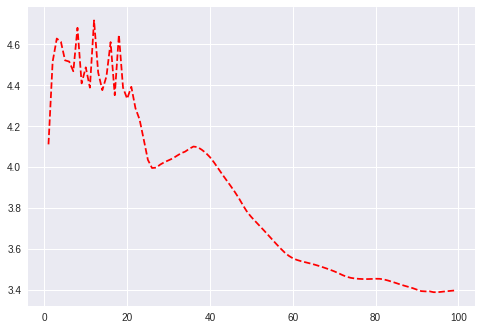

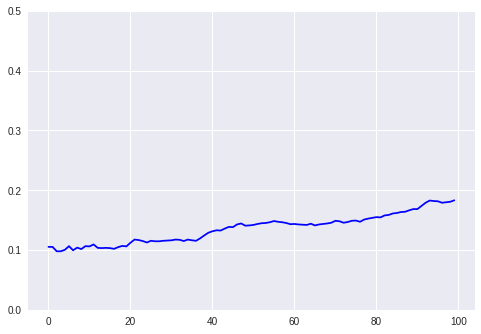

In [35]:
res = np.array(best_pred[2])
epoch = np.arange(len(res))

plt.figure(1)
plt.plot(epoch[1:], res[:,1][1:], 'r--')



plt.figure(2)
plt.plot(epoch, res[:,0], 'b')
plt.ylim(0, 0.5)

plt.show()